In [79]:
import os
import torch
import scipy
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from tqdm import tqdm
import plotly.express as px
import plotly.graph_objects as go

from tools.data_setter import cifar_100_setter
from tools.generator import generate_sample_info
from models import cifar, imagenet

In [80]:
def get_entropy(img):
    probs = torch.softmax(teacher(img), dim=1)
    log_probs = torch.log(probs)
    entropy = -torch.sum(probs*log_probs, dim = 1 )
    pred_label = torch.argmax(probs).item()
    return pred_label, entropy

device = torch.device('cuda:1')

teacher = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
student = cifar.WideResNet(depth=16, widen_factor=2, num_classes=100)
filename = "./model_checkpoints/cifar100/None/wrn-16-2/cr_all/WRN16_2_cr_all.t1"
filename_student = './model_checkpoints/cifar100/None/wrn-16-2/\
alp_0.1_T_20.0/wrn-16-2_alp1.0_t20.0_acq_entropy_lower0.0_upper1.0_validA0.0_seed_111.t1'
#filename = './model_checkpoints/cifar100/None/wrn-28-4/alp_0.1_T_1.0/random_highest_1.0_random_highest_1.0_seed9999.t1'

checkpoint = torch.load(filename, map_location=device)['nets']['199']
checkpoint_student = torch.load(filename_student, map_location=device)['199'] 
teacher.load_state_dict(checkpoint, strict=False)
teacher.eval()
student.load_state_dict(checkpoint_student, strict=True)
student.eval()

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, mome

In [81]:
generate_sample_info(teacher, dataset="cifar100", root='/home/osilab7/hdd/cifar',
                    model_name="/".join(filename_student.split('/')[2:])
                    ,device=device)

# dataset fix
dataloaders, dataset_size = cifar_100_setter(teacher=teacher,
                                             mode=None,
                                             batch_size=128,
                                             root='/home/osilab7/hdd/cifar',
                                             model_name="/".join(filename_student.split('/')[2:]),
                                             cls_acq='random',
                                             cls_order='highest',
                                             zeta=1.0,
                                             sample_acq='random',
                                             sample_order='highest',
                                             delta=1.0)
   

teacher = teacher.to(device)
student = student.to(device)

Files already downloaded and verified
Files already downloaded and verified


In [82]:
for i, data in enumerate(dataloaders['train']):
    image = data[0].type(torch.FloatTensor).to(device)
    label = data[1].type(torch.LongTensor).to(device)

    if i==0:
        labels = label.cpu()
        teachers_labels = teacher(image).detach().cpu()
        entropys = get_entropy(image)[1].detach().cpu()
    else:
        labels = torch.cat([labels, label.cpu()])
        teachers_labels = torch.cat([teachers_labels, teacher(image).detach().cpu()], dim=0)
        entropy = get_entropy(image)[1].detach().cpu()
        entropys = torch.cat([entropys, entropy], dim=0)
        
accuracy = labels == torch.argmax(teachers_labels, dim=1)    
values, _ = torch.topk(teachers_labels, k=3, dim=1)
top1_top2_list = values[:,0]-values[:,1]

gt_list=[]
for i in range(len(teachers_labels)):
    gt_list.append(teachers_labels[i,labels[i].item()].item())
gt_list = torch.Tensor(gt_list)

top1_gt_list = values[:,0] - gt_list

teacher_df = pd.DataFrame({"label":labels.numpy(), "top1_top2":top1_top2_list.numpy(),
                         "top1_gt":top1_gt_list.numpy(), "accuracy":accuracy.numpy(),
                          "entropy":entropys.numpy()})

tld_list = []
for x in teacher_df.values:
    if x[-2] == 0 :
        tld_list.append(-x[2])
    else :
        tld_list.append(x[1])
teacher_df["tld"] = tld_list
teacher_df.head()

label  top1_top2   top1_gt  accuracy   entropy        tld
0     16   5.998676  0.000000         1  0.038389   5.998676
1     25   0.686217  0.686217         0  0.743815  -0.686217
2     31   8.333988  0.000000         1  0.003389   8.333988
3     32   5.098997  0.000000         1  0.038902   5.098997
4      9  13.712428  0.000000         1  0.000016  13.712428

In [83]:
for i, data in enumerate(dataloaders['train']):
    image = data[0].type(torch.FloatTensor).to(device)
    label = data[1].type(torch.LongTensor).to(device)

    if i==0:
        labels = label.cpu()
        students_labels = student(image).detach().cpu()
        entropys = get_entropy(image)[1].detach().cpu()
    else:
        labels = torch.cat([labels, label.cpu()])
        students_labels = torch.cat([students_labels, student(image).detach().cpu()], dim=0)
        entropy = get_entropy(image)[1].detach().cpu()
        entropys = torch.cat([entropys, entropy], dim=0)
        
accuracy = labels == torch.argmax(students_labels, dim=1)    
values, _ = torch.topk(students_labels, k=3, dim=1)
top1_top2_list = values[:,0]-values[:,1]

gt_list=[]
for i in range(len(students_labels)):
    gt_list.append(students_labels[i,labels[i].item()].item())
gt_list = torch.Tensor(gt_list)

top1_gt_list = values[:,0] - gt_list

student_df = pd.DataFrame({"label":labels.numpy(), "top1_top2":top1_top2_list.numpy(),
                         "top1_gt":top1_gt_list.numpy(), "accuracy":accuracy.numpy(),
                          "entropy":entropys.numpy()})

tld_list = []
for x in student_df.values:
    if x[-2] == 0 :
        tld_list.append(-x[2])
    else :
        tld_list.append(x[1])
student_df["tld"] = tld_list
student_df.head()

label  top1_top2  top1_gt  accuracy   entropy        tld
0     80   9.075706      0.0         1  0.003044   9.075706
1     91  11.729046      0.0         1  0.000526  11.729046
2     19   8.195236      0.0         1  0.007848   8.195236
3     88   5.436500      0.0         1  0.084032   5.436500
4     49   6.286567      0.0         1  0.026151   6.286567

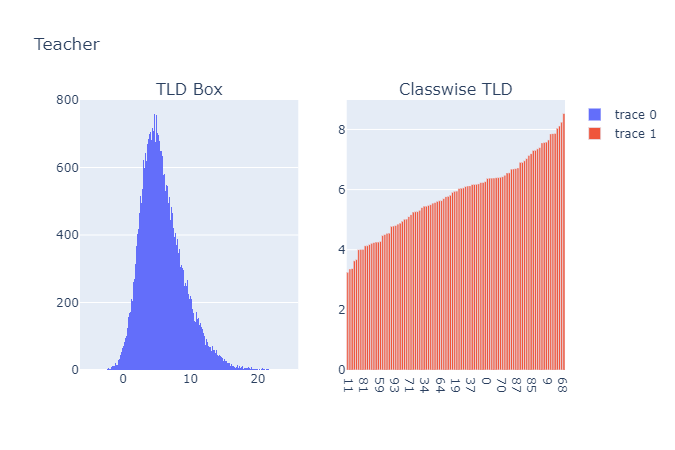

In [84]:
from plotly.subplots import make_subplots


df_plot = teacher_df.copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig =make_subplots(rows=1, cols=2, subplot_titles=("TLD Box", "Classwise TLD"))
fig.add_trace(go.Histogram(x=df_plot.tld), row=1, col=1)

grs = teacher_df.groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)
fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld), row=1, col=2)
fig.update_xaxes(type = 'category', row=1,col=2)

fig.update_layout(title="Teacher")

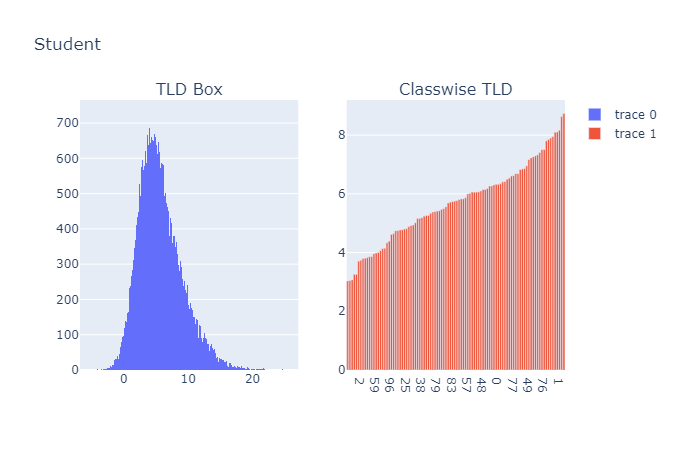

In [85]:
df_plot = student_df.copy()
df_plot.sort_values("tld", ascending=False ,inplace=True)
df_plot.reset_index(inplace=True)

fig =make_subplots(rows=1, cols=2, subplot_titles=("TLD Box", "Classwise TLD"))
fig.add_trace(go.Histogram(x=df_plot.tld), row=1, col=1)

grs = student_df.groupby("label")
df_plot = grs.mean()
df_plot.sort_values("tld" ,inplace=True)
fig.add_trace(go.Bar(x=df_plot.index, y=df_plot.tld), row=1, col=2)
fig.update_xaxes(type = 'category', row=1,col=2)

fig.update_layout(title="Student")

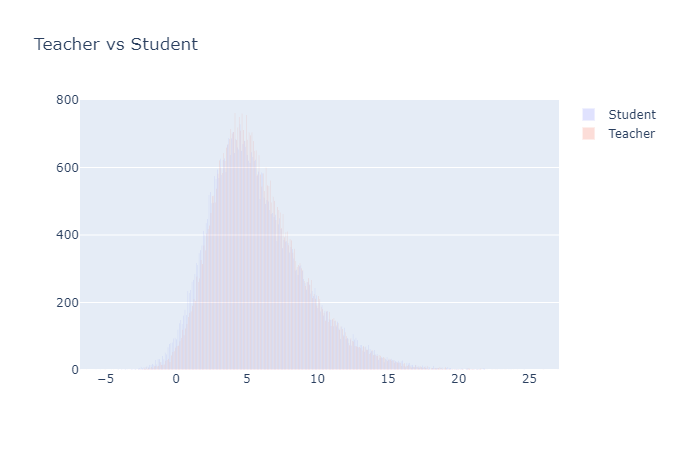

In [86]:
student_df_plot = student_df.copy()
teacher_df_plot = teacher_df.copy()

fig =go.Figure()
fig.add_trace(go.Histogram(x=student_df_plot.tld,name="Student", opacity=0.2))
fig.add_trace(go.Histogram(x=teacher_df_plot.tld,name="Teacher", opacity=0.2))

fig.update_layout(title="Teacher vs Student")